In [61]:
import csv
import os
from datetime import datetime
import math
import matplotlib.pyplot as plt

In [62]:
options_dir = '../data/options_data'
for ticker in os.listdir(options_dir):
    ticker_dir = options_dir + '/' + ticker
    call_files = []
    for file in os.listdir(ticker_dir):
        file_heruistics = file.split('_')
        strike = file_heruistics[2].split('-', 1)
        expiry_date = datetime.strptime(file_heruistics[1], '%Y%m%d').date()

        if 'c' in strike[0].replace('.csv', ''):
            call_files.append((file, expiry_date))

    call_files.sort(key=lambda contract: contract[1])

    #implement covered call strategy
    balance = 100000
    ownUnderlying = False
    underlyingQuantity = 0 # in hundreds

    csv_data = []

    for file, expiry_date in call_files:
        with open(os.path.join(ticker_dir, file), 'r') as f:
            strike_csv = csv.reader(f)
            row = list(strike_csv)

            for index, line in reversed(list(enumerate(row[0:len(row)-1]))):
                date = datetime.strptime(line[0], '%m/%d/%Y').date()
                if date.month == expiry_date.month:
                    start_open = float(row[index][1])
                    strike_price = float(row[index][16])
                    start_price = float(row[index][15])
                    end_price = float(row[1][15])
                    break

            # buy shares by the even hundreds + subtract balance
            if ownUnderlying == False:
                underlyingQuantity = math.floor(balance/(start_price * 100))
                balance -= (start_price * 100) * underlyingQuantity
                ownUnderlying = True

            # calculate profit of selling contract and add to balance
            contract_profit = underlyingQuantity * start_open * 100
            balance += contract_profit

            total_balance = balance + (underlyingQuantity * 100 * end_price)

            # obtain 'results'
            net_percentage = ((total_balance - 100000) / 100000) * 100
            net_return = total_balance - 100000

            csv_data.append([expiry_date, date, strike_price, start_price, end_price, start_open, underlyingQuantity, contract_profit, total_balance, net_percentage, net_return])

            # compare end asset price to strike price
            if end_price >= strike_price:
                stockSale = underlyingQuantity * 100 * end_price
                balance += stockSale

                ownUnderlying = False
                underlyingQuantity = 0

    with open('../data/outputs/covered_call/' + ticker + '.csv', 'w', newline="") as f:
        writer = csv.writer(f)

        header = ['Expiration Date', 'Date Contact Sold', 'Strike Price', 'Starting asset price', 'Ending Asset Price', 'Price Per Contract', 'Contracts Sold', 'Contract Profit', 'Monthly Ending Balance', 'Percent Change', 'Profit Amount']
        writer.writerow(header)

        for row in csv_data:
            writer.writerow(row)

F.csv
data points: 22
x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021']
y-axis values: [101120.0, 109520.0, 110796.0, 100095.0, 59751.0, 73650.0, 77524.0, 103897.0, 123792.0, 129157.0, 144844.0, 171594.0, 206670.0, 209569.0, 232538.0, 259716.0, 287364.0, 302468.0, 357848.0, 361704.0, 349895.0, 337122.0]
y2-axis vals: ['97685.19', '63888.89', '50810.19', '61458.33', '71990.74', '68171.3', '33564.81', '41782.41', '35416.67', '21875.0', '1736.11', '5092.59', '-10532.41', '-22916.67', '-21064.81', '-23495.37', '-29629.63', '-33912.04', '-41087.96', '-44097.22', '-19444.44', '2083.33', '7638.89', '4861.11']


ValueError: x and y must have same first dimension, but have shapes (22,) and (24,)

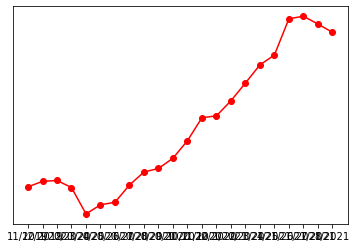

In [63]:
# graph results using matlab pyplot

outputs = '../data/outputs/covered_call/'
historical_outputs = '../data/outputs/historical_returns/'
files = [f for f in os.listdir(outputs) if os.path.isfile(os.path.join(outputs, f))]

for file in files:
    with open(os.path.join(outputs, file), 'r') as f:
        output_csv = csv.reader(f)
        rows = list(output_csv)
        
        profits = []
        monthly_balance = []
        months = []
        long_monthly_bal = []

        for line in rows[1:]:
            profits.append(round(float(line[10]), 2))
            monthly_balance.append(round(float(line[8]),2))
            date = datetime.strptime(line[0], "%Y-%m-%d").date()
            months.append(str(date.month) + '/' + str(date.year))

    with open(os.path.join(historical_outputs, file), 'r') as f:
        output_csv = csv.reader(f)
        rows = list(output_csv)
        for line in rows[1:]:
            long_monthly_bal.append(line[5])
    
    print(file)
    print("data points: " + str(len(monthly_balance)))
    print('x-axis values: ' + str(months))
    print('y-axis values: ' + str(monthly_balance))
    print('y2-axis vals: ' + str(long_monthly_bal))

    x1 = months
    y1 = monthly_balance
    y2 = long_monthly_bal

    figure, axis =  plt.subplots()
    axis.plot(x1, y1, color='red', marker='o')
    axis.plot(x1, y2, color='blue', marker='o')
    axis.set_xlabel("Month", fontsize=14)
    axis.set_ylabel("Portfolio Balance", fontsize=14)
    figure.set_figheight(10)
    figure.set_figwidth(20)
    axis.set_title(file.replace('.csv', '') + ' Balance v Time')

    figure.savefig('../data/outputs/covered_call/graphs/' + file.replace('.csv', '') + '_balance_v_time.jpg')
        
